# KNN Algorithm for Bitcoin Price Direction Prediction

This notebook implements a K-Nearest Neighbors (KNN) classifier to predict Bitcoin price direction (Up/Down) using treasury and sentiment data.

**Methodology:**
- Load Bitcoin sentiment dataset with treasury indicators
- Create binary classification target: price_direction (Up/Down) by comparing current close with previous day's close
- Remove OHLC features (open, high, low, close) to prevent data leakage
- Normalize numeric features for KNN distance calculations
- Use sklearn's KNeighborsClassifier (standard KNN implementation)
- Perform stratified train/test split (33% test size)
- Evaluate with accuracy, confusion matrix, and per-class metrics


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import random
import matplotlib.pyplot as plt

# Import mysklearn evaluation functions
from mysklearn.myevaluation import (
    stratified_train_test_split,
    confusion_matrix,
    accuracy_score,
    binary_precision_score,
    binary_recall_score,
    binary_f1_score
)

# Set random seed for reproducibility
random.seed(0)
np.random.seed(0)

print("Libraries Imported")

Libraries Imported


## Step 1: Load and Prepare Dataset


In [2]:
# Load the bitcoin sentiment dataset
df = pd.read_csv('input_data/bitcoin_sentiment.csv')

print("Dataset Shape:")
print(f"  Rows: {df.shape[0]}")
print(f"  Columns: {df.shape[1]}")
print()
print("Column Headers:")
print(df.columns.tolist())
print()
print("First 5 Rows:")
print(df.head())
print()


Dataset Shape:
  Rows: 1074
  Columns: 28

Column Headers:
['Unnamed: 0', 'timestamp', 'open', 'high', 'low', 'close', 'volume', 'datetime_utc', 'merge_date', 'domestic_series', 'federal_financing_bank', 'foreign_series', 'government_account_series', 'government_account_series_inflation_securities', 'special_purpose_vehicle', 'state_and_local_government_series', 'total_interest-bearing_debt', 'total_marketable', 'total_non-marketable', 'treasury_bills', 'treasury_bonds', 'treasury_floating_rate_notes_(frn)', 'treasury_inflation-protected_securities_(tips)', 'treasury_notes', 'united_states_savings_inflation_securities', 'united_states_savings_securities', 'weighted_sentiment', 'sentiment_missing']

First 5 Rows:
   Unnamed: 0      timestamp      open      high       low     close  \
0           0  1669852800000  17165.44  17317.80  16855.00  16980.08   
1           1  1669939200000  16980.07  17108.25  16791.02  17094.71   
2           2  1670025600000  17094.25  17158.42  16863.58  16

## Step 2: Create Price Direction Target


In [3]:
# Create the price_direction label by comparing close with previous day's close
df['price_direction'] = 'Down'  # Default value

# Compare current close with previous close
for i in range(1, len(df)):
    if df.loc[i, 'close'] > df.loc[i-1, 'close']:
        df.loc[i, 'price_direction'] = 'Up'
    else:
        df.loc[i, 'price_direction'] = 'Down'

# Remove the first row (no previous day to compare)
df = df.iloc[1:].copy()
df = df.reset_index(drop=True)

print("Price Direction Distribution:")
print(df['price_direction'].value_counts())
print()
print("Label Proportions:")
print(df['price_direction'].value_counts(normalize=True))
print()
print(f"Total instances: {len(df)}")
print()


Price Direction Distribution:
price_direction
Up      543
Down    530
Name: count, dtype: int64

Label Proportions:
price_direction
Up      0.506058
Down    0.493942
Name: proportion, dtype: float64

Total instances: 1073



## Step 3: Remove Data Leakage Features

Remove OHLC (open, high, low, close) features to prevent temporal leakage. The model should predict using only volume, sentiment, and macroeconomic indicators.


In [4]:
# Features to drop: OHLC prices and metadata columns
columns_to_drop = [
    'timestamp', 'open', 'high', 'low', 'close',  # Price data (leakage)
    'datetime_utc', 'merge_date',  # Date metadata
    'sentiment_missing',  # Missing indicator (not a feature)
    'price_direction'  # Target variable (will be extracted separately)
]

# Create feature dataframe
df_features = df.drop(columns=columns_to_drop, errors='ignore')

print("Features after removing leakage columns:")
print(f"  Remaining columns: {df_features.shape[1]}")
print(f"  Feature names: {df_features.columns.tolist()}")
print()
print("Data types:")
print(df_features.dtypes)
print()


Features after removing leakage columns:
  Remaining columns: 20
  Feature names: ['Unnamed: 0', 'volume', 'domestic_series', 'federal_financing_bank', 'foreign_series', 'government_account_series', 'government_account_series_inflation_securities', 'special_purpose_vehicle', 'state_and_local_government_series', 'total_interest-bearing_debt', 'total_marketable', 'total_non-marketable', 'treasury_bills', 'treasury_bonds', 'treasury_floating_rate_notes_(frn)', 'treasury_inflation-protected_securities_(tips)', 'treasury_notes', 'united_states_savings_inflation_securities', 'united_states_savings_securities', 'weighted_sentiment']

Data types:
Unnamed: 0                                          int64
volume                                            float64
domestic_series                                   float64
federal_financing_bank                            float64
foreign_series                                    float64
government_account_series                         float64
gover

## Step 4: Prepare Data for KNN

KNN requires numeric features. Convert all features to numeric and normalize.


In [5]:
# Convert all features to numeric (KNN requires numeric input)
# Handle any non-numeric columns
for col in df_features.columns:
    if df_features[col].dtype == 'object':
        # Try to convert to numeric
        df_features[col] = pd.to_numeric(df_features[col], errors='coerce')
        # Fill any NaN values created during conversion with 0
        df_features[col] = df_features[col].fillna(0)

# Ensure all columns are numeric
df_features = df_features.select_dtypes(include=[np.number])

print("Numeric features prepared:")
print(f"  Number of features: {df_features.shape[1]}")
print(f"  Feature names: {df_features.columns.tolist()}")
print()
print("Feature statistics (before normalization):")
print(df_features.describe().round(4))
print()

# Normalize features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_features)
df_features_scaled = pd.DataFrame(X_scaled, columns=df_features.columns)

print("Features normalized:")
print("Feature statistics (after normalization):")
print(df_features_scaled.describe().round(4))
print()


Numeric features prepared:
  Number of features: 20
  Feature names: ['Unnamed: 0', 'volume', 'domestic_series', 'federal_financing_bank', 'foreign_series', 'government_account_series', 'government_account_series_inflation_securities', 'special_purpose_vehicle', 'state_and_local_government_series', 'total_interest-bearing_debt', 'total_marketable', 'total_non-marketable', 'treasury_bills', 'treasury_bonds', 'treasury_floating_rate_notes_(frn)', 'treasury_inflation-protected_securities_(tips)', 'treasury_notes', 'united_states_savings_inflation_securities', 'united_states_savings_securities', 'weighted_sentiment']

Feature statistics (before normalization):
       Unnamed: 0      volume  domestic_series  federal_financing_bank  \
count   1073.0000   1073.0000         1073.000               1073.0000   
mean     537.0000  12271.7037            7.577                  2.4755   
std      309.8927   9026.0226            0.000                  0.0526   
min        1.0000   1227.7680          

## Step 5: Prepare Data for Training

Convert to list format for mysklearn functions and extract target variable.


In [6]:
# Convert features to list of lists (required by mysklearn functions)
X = df_features_scaled.values.tolist()

# Extract target variable
y = df['price_direction'].tolist()

print(f"X shape: {len(X)} samples, {len(X[0])} features")
print(f"y shape: {len(y)} labels")
print(f"Class distribution: {pd.Series(y).value_counts().to_dict()}")
print()


X shape: 1073 samples, 20 features
y shape: 1073 labels
Class distribution: {'Up': 543, 'Down': 530}



## Step 6: Stratified Train/Test Split

Split data into training (80%) and test (20%) sets while maintaining class distribution.


In [7]:
# Perform stratified train/test split (33% test size)
X_train, X_test, y_train, y_test = stratified_train_test_split(
    X, y, 
    test_size=0.20, 
    random_state=3, 
    shuffle=True
)

print("Train/Test Split Summary:")
print(f"  Training samples: {len(X_train)}")
print(f"  Test samples: {len(X_test)}")
print()
print("Training set class distribution:")
print(pd.Series(y_train).value_counts().to_dict())
print()
print("Test set class distribution:")
print(pd.Series(y_test).value_counts().to_dict())
print()


Train/Test Split Summary:
  Training samples: 858
  Test samples: 215

Training set class distribution:
{'Up': 434, 'Down': 424}

Test set class distribution:
{'Up': 109, 'Down': 106}



## Step 7: Train KNN Model

Train KNeighborsClassifier with k=5 (default) neighbors.


In [8]:
# Convert training data to numpy arrays for sklearn
X_train_array = np.array(X_train)
X_test_array = np.array(X_test)

# Initialize and train KNN classifier (k=5 by default)
knn = KNeighborsClassifier(n_neighbors=40)
knn.fit(X_train_array, y_train)

print("KNN model trained successfully")
print(f"  Number of neighbors: {knn.n_neighbors}")
print(f"  Training samples: {len(X_train)}")
print()


KNN model trained successfully
  Number of neighbors: 40
  Training samples: 858



## Step 8: Make Predictions

Generate predictions on the test set.


In [9]:
# Make predictions on test set
y_pred = knn.predict(X_test_array).tolist()

print("Predictions generated:")
print(f"  Test samples: {len(y_test)}")
print(f"  Predictions: {len(y_pred)}")
print()
print("Predicted class distribution:")
print(pd.Series(y_pred).value_counts().to_dict())
print()


Predictions generated:
  Test samples: 215
  Predictions: 215

Predicted class distribution:
{'Down': 111, 'Up': 104}



## Step 9: Evaluate Model Performance

Calculate accuracy, confusion matrix, precision, recall, and F1 score.


In [10]:
# Get unique labels for confusion matrix
labels = sorted(list(set(y_test + y_pred)))

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Model Performance Metrics:")
print(f"  Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print()

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred, labels)
print("Confusion Matrix:")
print(f"  Labels: {labels}")
for i, row in enumerate(cm):
    print(f"  {labels[i]}: {row}")
print()

# Calculate precision, recall, and F1 for each class
print("Per-Class Metrics:")
for label in labels:
    precision = binary_precision_score(y_test, y_pred, labels=labels, pos_label=label)
    recall = binary_recall_score(y_test, y_pred, labels=labels, pos_label=label)
    f1 = binary_f1_score(y_test, y_pred, labels=labels, pos_label=label)
    
    print(f"  {label}:")
    print(f"    Precision: {precision:.4f}")
    print(f"    Recall: {recall:.4f}")
    print(f"    F1 Score: {f1:.4f}")
print()


Model Performance Metrics:
  Accuracy: 0.4093 (40.93%)

Confusion Matrix:
  Labels: ['Down', 'Up']
  Down: [45, 61]
  Up: [66, 43]

Per-Class Metrics:
  Down:
    Precision: 0.4054
    Recall: 0.4245
    F1 Score: 0.4147
  Up:
    Precision: 0.4135
    Recall: 0.3945
    F1 Score: 0.4038



## Step 10: Hyperparameter Tuning - K Values from 1 to 100

Test different k values (1-100) across 5 different random states to find optimal number of neighbors.


In [11]:
# Hyperparameter tuning: Test k values from 1 to 100 across 5 random states
random_states = [0, 1, 2, 3, 4]
k_values = list(range(1, 101))  # k from 1 to 100

# Store results: {random_state: {k: accuracy}}
results = {rs: {} for rs in random_states}
all_accuracies = []  # For overall statistics

print("Starting hyperparameter tuning...")
print(f"  Random states: {random_states}")
print(f"  K values to test: 1 to 100 ({len(k_values)} values)")
print(f"  Total experiments: {len(random_states) * len(k_values)}")
print()

# Convert features to numpy array once (before loop)
X_array = np.array(X)

# Test each random state
for rs in random_states:
    print(f"Testing random_state={rs}...")
    
    # Split data with current random state
    X_train, X_test, y_train, y_test = stratified_train_test_split(
        X, y,
        test_size=0.20,
        random_state=rs,
        shuffle=True
    )
    
    # Convert to numpy arrays
    X_train_array = np.array(X_train)
    X_test_array = np.array(X_test)
    
    # Test each k value
    for k in k_values:
        # Train KNN with k neighbors
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train_array, y_train)
        
        # Make predictions
        y_pred = knn.predict(X_test_array).tolist()
        
        # Calculate accuracy
        acc = accuracy_score(y_test, y_pred)
        results[rs][k] = acc
        all_accuracies.append(acc)
    
    print(f"  Completed random_state={rs}")

print()
print("Hyperparameter tuning completed!")
print(f"  Best test accuracy: {max(all_accuracies):.4f}")
print(f"  Mean test accuracy: {np.mean(all_accuracies):.4f}")
print()


Starting hyperparameter tuning...
  Random states: [0, 1, 2, 3, 4]
  K values to test: 1 to 100 (100 values)
  Total experiments: 500

Testing random_state=0...
  Completed random_state=0
Testing random_state=1...
  Completed random_state=1
Testing random_state=2...
  Completed random_state=2
Testing random_state=3...
  Completed random_state=3
Testing random_state=4...
  Completed random_state=4

Hyperparameter tuning completed!
  Best test accuracy: 0.5721
  Mean test accuracy: 0.4912



## Step 11: Visualize Results

Create graphs showing accuracy vs k values for each random state and overall trends.


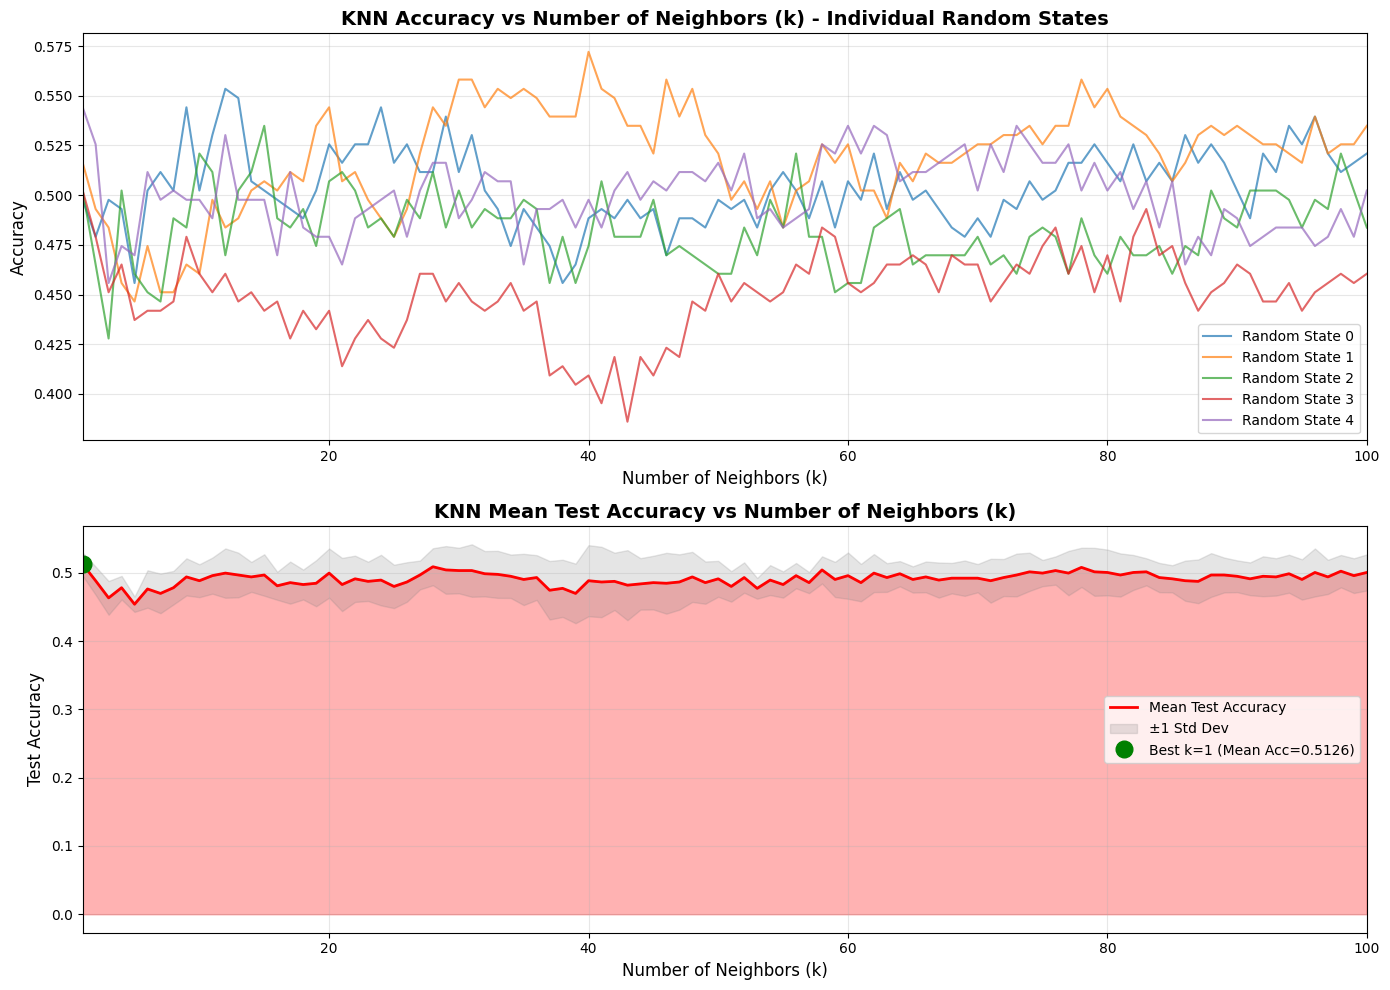

Best k value: 1 with mean test accuracy: 0.5126
Mean test accuracy range: [0.4540, 0.5126]



In [12]:
# Create visualization
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Individual random states
ax1 = axes[0]
for rs in random_states:
    k_vals = sorted(results[rs].keys())
    acc_vals = [results[rs][k] for k in k_vals]
    ax1.plot(k_vals, acc_vals, label=f'Random State {rs}', alpha=0.7, linewidth=1.5)

ax1.set_xlabel('Number of Neighbors (k)', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('KNN Accuracy vs Number of Neighbors (k) - Individual Random States', fontsize=14, fontweight='bold')
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(1, 100)

# Plot 2: Mean test accuracy across all random states
ax2 = axes[1]
mean_test_accuracies = []
for k in k_values:
    accs_for_k = [results[rs][k] for rs in random_states]
    mean_test_accuracies.append(np.mean(accs_for_k))

ax2.plot(k_values, mean_test_accuracies, color='red', linewidth=2, label='Mean Test Accuracy')
ax2.fill_between(k_values, mean_test_accuracies, alpha=0.3, color='red')

# Add standard deviation bands
std_accuracies = []
for k in k_values:
    accs_for_k = [results[rs][k] for rs in random_states]
    std_accuracies.append(np.std(accs_for_k))

upper_bound = [mean_test_accuracies[i] + std_accuracies[i] for i in range(len(mean_test_accuracies))]
lower_bound = [mean_test_accuracies[i] - std_accuracies[i] for i in range(len(mean_test_accuracies))]
ax2.fill_between(k_values, lower_bound, upper_bound, alpha=0.2, color='gray', label='±1 Std Dev')

ax2.set_xlabel('Number of Neighbors (k)', fontsize=12)
ax2.set_ylabel('Test Accuracy', fontsize=12)
ax2.set_title('KNN Mean Test Accuracy vs Number of Neighbors (k)', fontsize=14, fontweight='bold')
ax2.legend(loc='best', fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(1, 100)

# Find and mark best k
best_k_idx = np.argmax(mean_test_accuracies)
best_k = k_values[best_k_idx]
best_acc = mean_test_accuracies[best_k_idx]
ax2.plot(best_k, best_acc, 'go', markersize=12, label=f'Best k={best_k} (Mean Acc={best_acc:.4f})')
ax2.legend(loc='best', fontsize=10)

plt.tight_layout()
plt.show()

print(f"Best k value: {best_k} with mean test accuracy: {best_acc:.4f}")
print(f"Mean test accuracy range: [{min(mean_test_accuracies):.4f}, {max(mean_test_accuracies):.4f}]")
print()


In [13]:
# Summary statistics table
summary_data = []
for k in k_values:
    accs_for_k = [results[rs][k] for rs in random_states]
    summary_data.append({
        'k': k,
        'mean_test_accuracy': np.mean(accs_for_k),
        'std_accuracy': np.std(accs_for_k),
        'min_accuracy': np.min(accs_for_k),
        'max_accuracy': np.max(accs_for_k)
    })

summary_df = pd.DataFrame(summary_data)

# Display top 10 k values
print("Top 10 k values by mean test accuracy:")
print(summary_df.nlargest(10, 'mean_test_accuracy')[['k', 'mean_test_accuracy', 'std_accuracy', 'min_accuracy', 'max_accuracy']].to_string(index=False))
print()


Top 10 k values by mean test accuracy:
 k  mean_test_accuracy  std_accuracy  min_accuracy  max_accuracy
 1            0.512558      0.017001      0.497674      0.544186
28            0.508837      0.027057      0.460465      0.544186
78            0.507907      0.028732      0.474419      0.558140
29            0.504186      0.034881      0.446512      0.539535
58            0.504186      0.019864      0.479070      0.525581
30            0.503256      0.033333      0.455814      0.558140
31            0.503256      0.038400      0.446512      0.558140
76            0.503256      0.020675      0.479070      0.534884
98            0.502326      0.023716      0.460465      0.525581
79            0.501395      0.035103      0.451163      0.544186

